In [1]:
#Importing the packages implemented in this notebook.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# 1)Data Import

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
def dataInfo(dataset):
    '''A function to summarize a dataset properties.'''
    
    print(f'shape: {dataset.shape}')
    print('*****************************')
    print(f'data types:\n')
    print(f"{dataset.dtypes}")
    print('*****************************')
    print(f'Total missed values: {dataset.isnull().sum().sum()}')    
    print('*****************************')
    print(f'Missed values in each column:\n')
    print(f"{dataset.isnull().sum()}")

## 1-1)Train set

In [5]:
dataInfo(train)

shape: (891, 12)
*****************************
data types:

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
*****************************
Total missed values: 866
*****************************
Missed values in each column:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


# 2) Data Exploratory Analysis

## 2-1)Missing Values

In [6]:
def nullFraction(col,df="train"):
    '''This function prints the null fraction of a column.'''
    print("Null vlaue fraction of the {} feature in the {} set: {:.2f}".format(col,df, np.mean(train[col].isna())))
    

The first issue that the dataInfo output attracts our attention is the null values includig in the "Cabin" feature. Almost 80 percent of the data of this feature is not known.

In [7]:
nullFraction("Cabin")
nullFraction("Cabin", "test")

Null vlaue fraction of the Cabin feature in the train set: 0.77
Null vlaue fraction of the Cabin feature in the test set: 0.77


This statistic for the "Age" is about 20 percent.

In [8]:
nullFraction("Age")
nullFraction("Age", "test")

Null vlaue fraction of the Age feature in the train set: 0.20
Null vlaue fraction of the Age feature in the test set: 0.20


Visually we may see these statistics better:

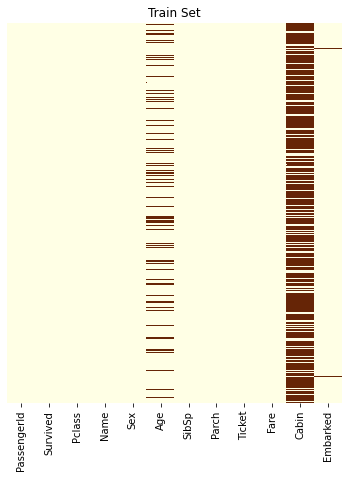

In [9]:
fig,ax0 = plt.subplots(figsize=(6,7))
sns.heatmap(train.isnull(), yticklabels=False,cmap="YlOrBr", cbar=False, ax=ax0);
ax0.set_title("Train Set")
plt.show()

As it is mentioned earlier about 20 percent of the "Age" is missing. This amount of missing might be reasonable to iplement an imputution method to replace the missing data, however, such an approach could not be helpful for the "Cabin" as it contains about 80 percent missing data. 

## 2-2)Class Distribution

Now let's explore the distribution of the class labels to see how the featurse can explain the target categories.


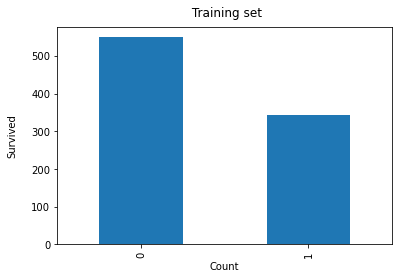

In [10]:
fig, ax1 = plt.subplots( )
train['Survived'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ax1.set_xlabel("Count")
ax1.set_ylabel("Survived", labelpad=14)
ax1.set_title(" Training set", y=1.02);

The following are the visualization of the distribution of the "Survived" based on the different features:

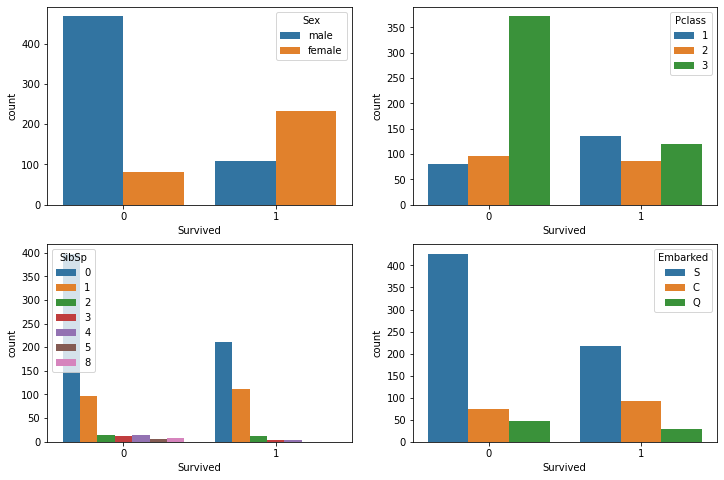

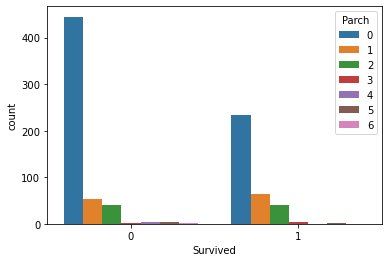

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
sns.countplot(x="Survived", hue="Sex", data=train, ax=ax[0,0])
sns.countplot(x="Survived", hue="Pclass", data=train, ax=ax[0,1])

sns.countplot(x="Survived", hue="SibSp", data=train, ax=ax[1,0])
sns.countplot(x="Survived", hue="Embarked", data=train, ax=ax[1,1])
plt.show()

sns.countplot(x="Survived", hue="Parch", data=train);

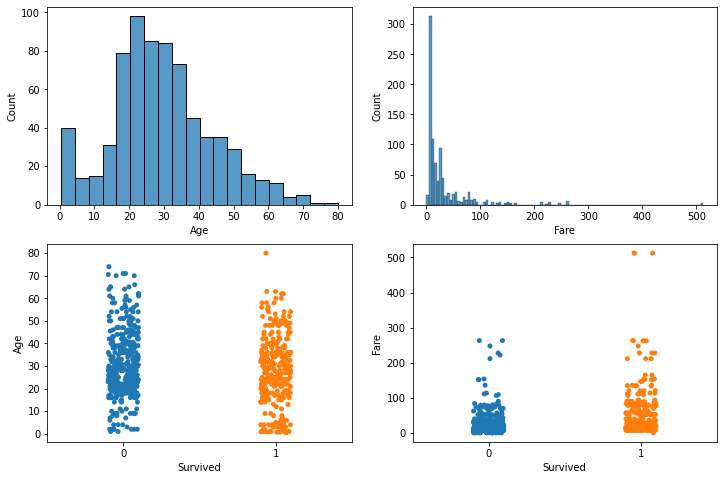

In [12]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
sns.histplot(data=train.Age, ax=ax[0,0]);
sns.histplot(data=train.Fare, ax = ax[0,1]);
sns.stripplot(x="Survived", y="Age", data=train, ax=ax[1,0]);
sns.stripplot(x="Survived", y="Fare", data=train, ax=ax[1,1]);

None of the features alone can explain the target perfect. As the figures illustrate each of those features can distinguish between two categories to some extent. 

we need to drop the "Cabin" as the most of its values are missing.

"Name" and "Ticket" may not be helpful to classify the target as their values are unique.

Therefore the features which may be selected to move forward with includes:

**'Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked'**

In [13]:
print("Unique values of the Ticket:{}".format(len(train.Ticket.unique())))
print("Unique values of the Name:{}".format(len(train.Name.unique())))


Unique values of the Ticket:681
Unique values of the Name:891


# 3) Data Preparation

## 3-1) Fill in the Missing data

As the first step we need to fill in the missing values. As we saw earlier "Age" and "Embarked" have some missing data which must be filled in. 

To replace the "Age" missing values with proper values we need to explore the relationship between "Age" and other features.

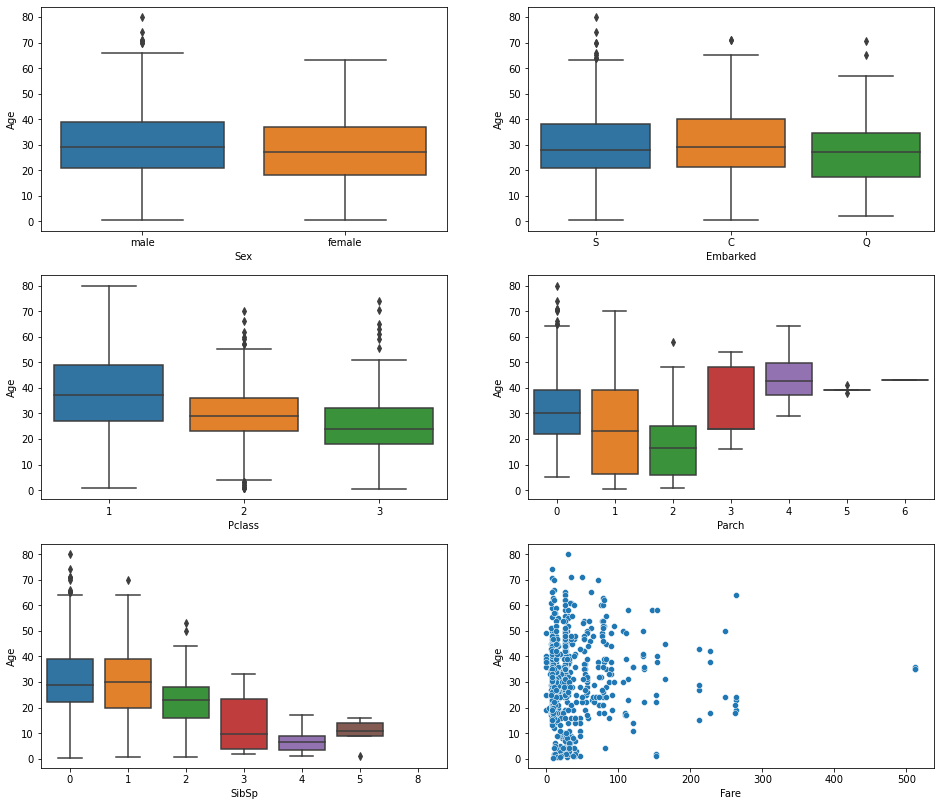

In [14]:
fig, ax = plt.subplots(3,2, figsize=(16,14))
sns.boxplot(x="Sex", y="Age", data=train, ax=ax[0,0] )
sns.boxplot(x="Embarked", y="Age" ,data=train, ax=ax[0,1])
sns.boxplot(x="Pclass", y="Age", data=train, ax=ax[1,0] )
sns.boxplot(x="Parch", y="Age", data= train, ax=ax[1,1] )
sns.boxplot(x="SibSp", y="Age", data= train, ax=ax[2,0] )
sns.scatterplot(x="Fare", y="Age", data= train, ax=ax[2,1] )
plt.show()


Among the features, it seems that only "Pclass", "Parch", and "SibSp" may help us in order to fill the missing value in "Age" column.
To select the best one let's compute the average value of "Age" for each of those Features:

In [15]:
print("Mean values of 'Age' per 'Pcalss' categories:")
print(train.groupby(["Pclass"])["Age"].mean())
print("*****************************")
print("Mean values of 'Age' per 'Parch' categories:")
print(train.groupby(["Parch"])["Age"].mean())
print("*****************************")
print("Mean values of 'Age' per 'SibSp' categories:")
print(train.groupby(["SibSp"])["Age"].mean())

Mean values of 'Age' per 'Pcalss' categories:
Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64
*****************************
Mean values of 'Age' per 'Parch' categories:
Parch
0    32.178503
1    24.422000
2    17.216912
3    33.200000
4    44.500000
5    39.200000
6    43.000000
Name: Age, dtype: float64
*****************************
Mean values of 'Age' per 'SibSp' categories:
SibSp
0    31.397558
1    30.089727
2    22.620000
3    13.916667
4     7.055556
5    10.200000
8          NaN
Name: Age, dtype: float64


The results show that we can use either "Pclass" or "Parch" values to fill in "Age" missing data. Since the "Age" seems to be more distributed across the "Parch" classes, it might be more reasonable to use this feature for the filling in process. So let's fill in the "Age" missing values using the "Parch" feature. A simple function and then FunctionTransformer is implemented to make it possible to be used in a pipeline transform process.

In [16]:
def ageImputer(X):
    X['Age'] = X['Age'].fillna(train.groupby(['Parch'])['Age'].transform(np.mean))
    return X

In addition to "Age" missing values, "Embarked" also contains two missing values:

In [17]:
train[train["Embarked"].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


As we can see "Sex", "Pclass", "Parch", and "SibSp" are identical for these two rows which are "female", 1, 0, 0 respectively. We can fill in these two missing data based on the majority vote of those values. The following result candidate "S" as a suitable value for the missing data.

In [18]:
print(train.groupby(["Sex"])["Embarked"].value_counts())
print(train.groupby(["Pclass"])["Embarked"].value_counts())

Sex     Embarked
female  S           203
        C            73
        Q            36
male    S           441
        C            95
        Q            41
Name: Embarked, dtype: int64
Pclass  Embarked
1       S           127
        C            85
        Q             2
2       S           164
        C            17
        Q             3
3       S           353
        Q            72
        C            66
Name: Embarked, dtype: int64


In [19]:
train['Embarked'] = train['Embarked'].fillna('S')

## 3-2)Droping unhelpful features

As is is explained earlier we need to drop {"Name", "Ticket", "Cabin"} from our data.

In [20]:
# def featuresDropper(X):
#     return X.drop(columns=["Name", "Ticket", "Cabin"])

def featuresDropper(X):
    return X.drop(columns=["Name", "Ticket"])

def featuresAdder(X):
    X['Cabin']=X['Cabin'].map(lambda c: 0 if pd.isnull(c) else 1)
    return X
    

## 3-3) Categorical features to numerical

Another important step in feature preparation is to map the categorical values into some numerical values in order to be able to feed the machine learning algorithm with the categorical inputs. As we noticed earlier "Sex" and "Embarked" values are not numeric. To map those features into numerical ones, pandas get_dummies function is implemented.

In [21]:
# def catToDum(X):
#     sex_df = pd.get_dummies(X['Sex'],drop_first=True)
#     embark_df = pd.get_dummies(X['Embarked'],drop_first=True)
#     finalData = X.drop(["Sex", "Embarked"], axis=1)
#     return pd.concat([finalData, sex_df, embark_df], axis=1)

def catToDum(X):
    X["Sex"] = X["Sex"].map({'male':1, 'female':0})
    X["Embarked"] = X["Embarked"].map({'C':0, 'S':1, 'Q':2})    
    return X

Having all the preprocessing functions at hand, we now can simply use the pipeline process from sklearn to transform our dataset to the prepared data in order to train the machine learning classifiers.

In [22]:
prep_pipeline = Pipeline([
        ('imputer', FunctionTransformer(ageImputer, validate=False)),
        ('features_droper', FunctionTransformer(featuresDropper, validate=False)),
        ('features_adder', FunctionTransformer(featuresAdder, validate=False)),
        ('cat_to_dum', FunctionTransformer(catToDum, validate=False))
    ])

finalData = prep_pipeline.fit_transform(train)

finalData.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,1,22.0,1,0,7.2500,0,1
1,2,1,1,0,38.0,1,0,71.2833,1,0
2,3,1,3,0,26.0,0,0,7.9250,0,1
3,4,1,1,0,35.0,1,0,53.1000,1,1
4,5,0,3,1,35.0,0,0,8.0500,0,1


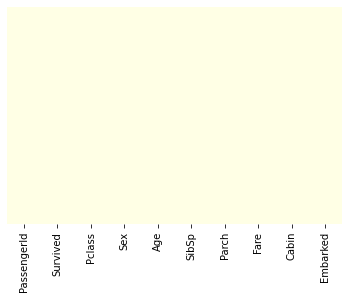

In [23]:
sns.heatmap(finalData.isnull(), yticklabels=False,cmap="YlOrBr", cbar=False);

As it is obvious, the dataset contains no missing data. The unhelpful columns have been dropped and the categorical features have been converted to their dumies.
The data set is now ready to train the models and evaluate them. To do so we need to split the data into train and test sets.

## 3-4) Splitting the final data into train and test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(finalData[['Pclass', 'Age', 'SibSp', 'Parch','Fare','Cabin', 'Sex', 'Embarked']],
                                                    finalData[['Survived']], test_size=0.15, random_state=41,
                                                    stratify=finalData[['Survived']])

In [25]:
print('X_train Shape:{}'.format(X_train.shape))
print('y_train Shape:{}'.format(y_train.shape))
print('X_test Shape:{}'.format(X_test.shape))
print('y_test Shape:{}'.format(y_test.shape))

X_train Shape:(757, 8)
y_train Shape:(757, 1)
X_test Shape:(134, 8)
y_test Shape:(134, 1)


# 4)Training and Evaluation

The following are the various models have been trained on our training data. cross validation grid search was implemented to tune the hyperparameters and finally the best estimator was evaluated by applying it on our test set. A classification report consisting the acccuracy,F1, recall, and precision for each model is shown.

## 0)XGBClassifier

In [26]:
pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', XGBClassifier())])

params = {#'scaler__with_mean':(True, False),
          #'scaler__with_std':(True, False),
          'clf__n_estimators':(100, 500, 2000),
          'clf__max_depth':(3,4,5),
          'clf__min_child_weight':(2,3,4),
          'clf__subsample': (0.9, 0.8, 0.1)
         }

grid_search = GridSearchCV(pipeline, params, cv=10)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))


Best Parameters:

	clf__max_depth : 3
	clf__min_child_weight : 2
	clf__n_estimators : 100
	clf__subsample : 0.8

Best Score: 0.8282982456140351
Performance on the test data

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        83
           1       0.84      0.75      0.79        51

    accuracy                           0.85       134
   macro avg       0.85      0.83      0.84       134
weighted avg       0.85      0.85      0.85       134



## 4-1)NaiveBayes

In [100]:

pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', GaussianNB())])

params = {'scaler__with_mean':(True, False),
          'scaler__with_std':(True, False)
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))


Best Parameters:

	scaler__with_mean : True
	scaler__with_std : True

Best Score: 0.7689177413733008
Performance on the test data

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        83
           1       0.81      0.76      0.79        51

    accuracy                           0.84       134
   macro avg       0.84      0.83      0.83       134
weighted avg       0.84      0.84      0.84       134



## 4-2)Logistic Regression

In [30]:


pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', LogisticRegression())])

params = {#'scaler__with_mean':(True, False),
          #'scaler__with_std':(True, False),
          'clf__C':(0.01, 1, 10, 100)          
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))


Best Parameters:

	clf__C : 0.01

Best Score: 0.786066573719066
Performance on the test data

              precision    recall  f1-score   support

           0       0.82      0.96      0.88        83
           1       0.92      0.65      0.76        51

    accuracy                           0.84       134
   macro avg       0.87      0.81      0.82       134
weighted avg       0.85      0.84      0.84       134



## 4-3)KNeighborsClassifier

In [29]:


pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', KNeighborsClassifier())])

params = {'scaler__with_mean':(True, False),
          'scaler__with_std':(True, False),
          'clf__n_neighbors':(5,10),
          'clf__weights':('uniform', 'distance'),
          'clf__p':(1,2)
          
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))



Best Parameters:

	clf__n_neighbors : 10
	clf__p : 1
	clf__weights : uniform
	scaler__with_mean : True
	scaler__with_std : True

Best Score: 0.8044963401882189
Performance on the test data

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        83
           1       0.88      0.73      0.80        51

    accuracy                           0.86       134
   macro avg       0.86      0.83      0.84       134
weighted avg       0.86      0.86      0.85       134



## 4-4)SVC

In [28]:


pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', SVC())])

params = {'scaler__with_mean':(True, False),
          'scaler__with_std':(True, False),
          'clf__C':(0.5, 1),
          'clf__kernel':('poly', 'rbf', 'sigmoid')
           
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))



Best Parameters:

	clf__C : 1
	clf__kernel : rbf
	scaler__with_mean : True
	scaler__with_std : True

Best Score: 0.8151533635413035
Performance on the test data

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        83
           1       0.91      0.76      0.83        51

    accuracy                           0.88       134
   macro avg       0.89      0.86      0.87       134
weighted avg       0.88      0.88      0.88       134



## 4-5)DecisionTreeClassifier

In [104]:


pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', DecisionTreeClassifier())])

params = {'scaler__with_mean':(True, False),
          'scaler__with_std':(True, False),
          'clf__criterion': ('gini', 'entropy'),
          'clf__splitter': ('best', 'random'),
          'clf__max_features':('auto', 'sqrt','log2')
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))

Best Parameters:

	clf__criterion : entropy
	clf__max_features : auto
	clf__splitter : best
	scaler__with_mean : True
	scaler__with_std : True

Best Score: 0.7754356918787034
Performance on the test data

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        83
           1       0.77      0.73      0.75        51

    accuracy                           0.81       134
   macro avg       0.80      0.80      0.80       134
weighted avg       0.81      0.81      0.81       134



## 4-6)GradientBoostingClassifier

In [35]:


pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', GradientBoostingClassifier())])

params = {'scaler__with_mean':(True, False),
          'scaler__with_std':(True, False),
          'clf__learning_rate': (0.01, 0.1),            
          'clf__n_estimators': (100,200,300),
          'clf__subsample': (0.5, 1),          
          'clf__max_features':('auto', 'sqrt','log2')
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))


Best Parameters:

	clf__learning_rate : 0.1
	clf__max_features : auto
	clf__n_estimators : 100
	clf__subsample : 0.5
	scaler__with_mean : False
	scaler__with_std : True

Best Score: 0.819092018124782
Performance on the test data

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        83
           1       0.88      0.73      0.80        51

    accuracy                           0.86       134
   macro avg       0.86      0.83      0.84       134
weighted avg       0.86      0.86      0.85       134



## 4-7)RandomForestClassifier

In [32]:


pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', RandomForestClassifier())])

params = {'scaler__with_mean':(True, False),
          'scaler__with_std':(True, False),
          'clf__criterion': ('gini', 'entropy'),            
          'clf__n_estimators': (100,200,300),          
          'clf__max_features':('auto', 'sqrt','log2')
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))



Best Parameters:

	clf__criterion : entropy
	clf__max_features : log2
	clf__n_estimators : 100
	scaler__with_mean : True
	scaler__with_std : False

Best Score: 0.7966277448588358
Performance on the test data

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        83
           1       0.82      0.78      0.80        51

    accuracy                           0.85       134
   macro avg       0.84      0.84      0.84       134
weighted avg       0.85      0.85      0.85       134



## 4-8)AdaBoostClassifier

In [33]:


pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', AdaBoostClassifier())])

params = {'scaler__with_mean':(True, False),
          'scaler__with_std':(True, False),                      
          'clf__n_estimators': (50,150,200)          
          
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))



Best Parameters:

	clf__n_estimators : 150
	scaler__with_mean : True
	scaler__with_std : True

Best Score: 0.792645521087487
Performance on the test data

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        83
           1       0.82      0.78      0.80        51

    accuracy                           0.85       134
   macro avg       0.84      0.84      0.84       134
weighted avg       0.85      0.85      0.85       134



## 4-9)GaussianProcessClassifier

In [27]:


pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', GaussianProcessClassifier())])

params = {#'scaler__with_mean':(True, False),
          #'scaler__with_std':(True, False),
          'clf__kernel':(1*RBF(1),1*Matern(1,1.5), 1*RBF(0.5))
                   
          
         }

grid_search = GridSearchCV(pipeline, params, verbose=0)

grid_search.fit(X_train, y_train)

#Best score and parameters
print("Best Parameters:\n")
for k,v in grid_search.best_params_.items():
    print(f"\t{k} : {v}")
print()
print(f"Best Score: {grid_search.best_score_}")


#Best estimator
print("Performance on the test data")
bestEstimator = grid_search.best_estimator_

bestEstimator.fit(X_train, y_train)
pred = bestEstimator.predict(X_test)
print()
print(classification_report(y_test, pred))




Best Parameters:

	clf__kernel : 1**2 * RBF(length_scale=1)

Best Score: 0.8164604391774137
Performance on the test data

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        83
           1       0.91      0.76      0.83        51

    accuracy                           0.88       134
   macro avg       0.89      0.86      0.87       134
weighted avg       0.88      0.88      0.88       134



## 4-10)Voting Classifier

So far the best accuracy was obtained by the models Logistic Regression, KNeighborsClassifier, SVC, and GaussianProcessClassifier. Let's combine these different classifiers to use a majority vote to predict the class labels. This can be reached by VotingClassifier from sklearn.ensemble.

In [ ]:
clf__learning_rate : 0.1
	clf__max_features : auto
	clf__n_estimators : 100
	clf__subsample : 0.5

In [42]:
model1 = LogisticRegression(C=0.01)
model2 = KNeighborsClassifier(n_neighbors=10, p=1, weights='uniform')
model3 = SVC(C=1, kernel='rbf')
model4 = GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
model5 = XGBClassifier(n_estimators=100, max_depth=3, min_child_weight=2, subsample=0.8)


classifiers=[('lr', model1), ('kn', model2), ('svc', model3), ('gp', model4), ('xgb', model5)]

#Ensemble classifier
ensemble_clf = VotingClassifier(estimators=classifiers, voting='hard')

ens_pipeline = Pipeline([('scaler', StandardScaler()),                 
                     ('clf', ensemble_clf)])

ens_pipeline.fit(X_train, y_train)
pred = ens_pipeline.predict(X_test)
print()
print(classification_report(y_test, pred))




              precision    recall  f1-score   support

           0       0.87      0.98      0.92        83
           1       0.95      0.76      0.85        51

    accuracy                           0.90       134
   macro avg       0.91      0.87      0.88       134
weighted avg       0.90      0.90      0.89       134



It seems that the ensemble model could outperform the individual models. Therefore we continue with that to predict the class labels for the test set.

# 5) Predicting the class labels for the test set

Now we train a GaussianProcess Classifier on the whole training data to predict the class labels for the test set.

In [60]:
train= pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [61]:
#Using our preprocess pipeline to obtain the prepared data
train['Embarked'] = train['Embarked'].fillna('S')
trainData = prep_pipeline.fit_transform(train)

# trainData.head()
dataInfo(trainData)

shape: (891, 10)
*****************************
data types:

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Cabin            int64
Embarked         int64
dtype: object
*****************************
Total missed values: 0
*****************************
Missed values in each column:

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [62]:
#Prepared the test data
testData = prep_pipeline.fit_transform(test)

In [63]:
testData.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,1,34.5,0,0,7.8292,0,2
1,893,3,0,47.0,1,0,7.0000,0,1
2,894,2,1,62.0,0,0,9.6875,0,2
3,895,3,1,27.0,0,0,8.6625,0,1
4,896,3,0,22.0,1,1,12.2875,0,1


In [64]:
dataInfo(testData)

shape: (418, 9)
*****************************
data types:

PassengerId      int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Cabin            int64
Embarked         int64
dtype: object
*****************************
Total missed values: 1
*****************************
Missed values in each column:

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Cabin          0
Embarked       0
dtype: int64


As we can see there exist a missing value in the testData which belongs to Fare. We simply impute it using the median of the Fare values.

In [65]:
testData['Fare'].fillna(testData['Fare'].median(), inplace=True)

np.sum(testData.isna())

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [66]:
X_train, y_train = trainData[['Pclass', 'Age', 'SibSp', 'Parch','Fare','Cabin', 'Sex', 'Embarked']], trainData[['Survived']]
X_test = testData[['Pclass', 'Age', 'SibSp', 'Parch','Fare','Cabin', 'Sex', 'Embarked']]

In [67]:
#Training the ensemble classifier on the trainData
ens_pipeline.fit(X_train, y_train)
pred = ens_pipeline.predict(X_test)

print("Prediction:\n")
print(pred)

Prediction:

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0
 0 1 1 1 1 1 0 1 0 0 0]


In [68]:
testPrediction = pd.DataFrame({'PassengerId':testData['PassengerId'], 'Survived':pd.Series(pred)})

In [69]:
testPrediction.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [70]:
testPrediction.to_csv('submission3.csv', index=False)